<a href="https://colab.research.google.com/github/mking2014/final-4449-king/blob/main/age_binning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

In [176]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# def evaluate_classification_model(g_labels, g_preds):

#   cm = confusion_matrix(g_labels, g_preds)
#   sns.heatmap(cm, annot = True, fmt ='.0f')
#   plt.ylabel('True Label')
#   plt.xlabel('Predictied Label')
#   plt.title('Gender Classficiation')
#   print(f"Accuracy: {accuracy_score(g_labels, g_preds)}")
#   print(f"Precision: {precision_score(g_labels, g_preds)}")
#   print(f"Recall: {recall_score(g_labels, g_preds)}")
#   print(f"F1 Score: {f1_score(g_labels, g_preds)}")

#   return


# def get_model_results(model, data):
#   '''
#   IN: Model, model you would like to predict your results from
#   Data: DataFrame, Dataset you'd like ot predict results from
#   '''
#   predictions = []
#   labels = []

#   data = data.values.tolist()

#   for x in data:

#     labels.append((x[0], x[1]))

#     m_pred = model.predict(x[2].reshape(-1, 48, 48, 1), verbose = 0)

#     predictions.append((round(m_pred[1][0][0]), round(m_pred[0][0][0])))

#   return labels, predictions

# Load Data

Gender: Male = 0, Female = 1


In [178]:
df = pd.read_csv('/content/drive/MyDrive/comp4449_final/content 2/data/age_gender.csv')
df = df.drop(columns = ['img_name'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (23705, 4)


,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [179]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

# EDA

Text(0, 0.5, 'Count')

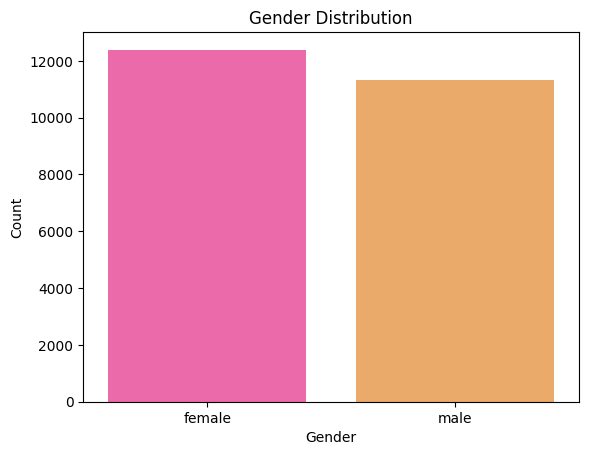

In [180]:
sns.countplot(x="gender", palette='spring', data=df.replace({"gender" : {1 : "male", 0 : "female"}}))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

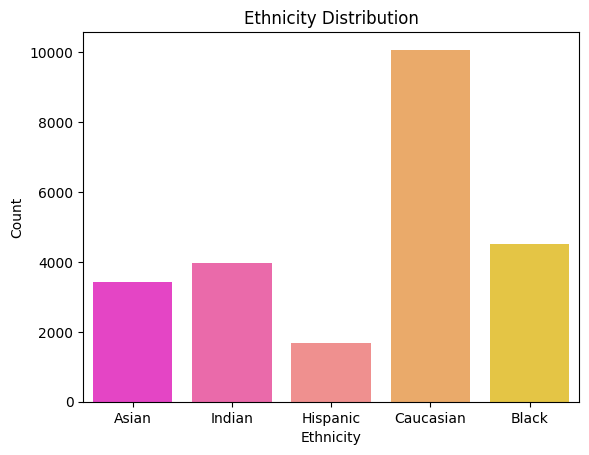

In [181]:
sns.countplot(x="ethnicity", palette='spring',
              data=df.replace({"ethnicity" : {0: "Caucasian", 1: "Black", 2: "Asian", 3:"Indian", 4:"Hispanic"}}))

plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')

Text(0.5, 0, 'Age')

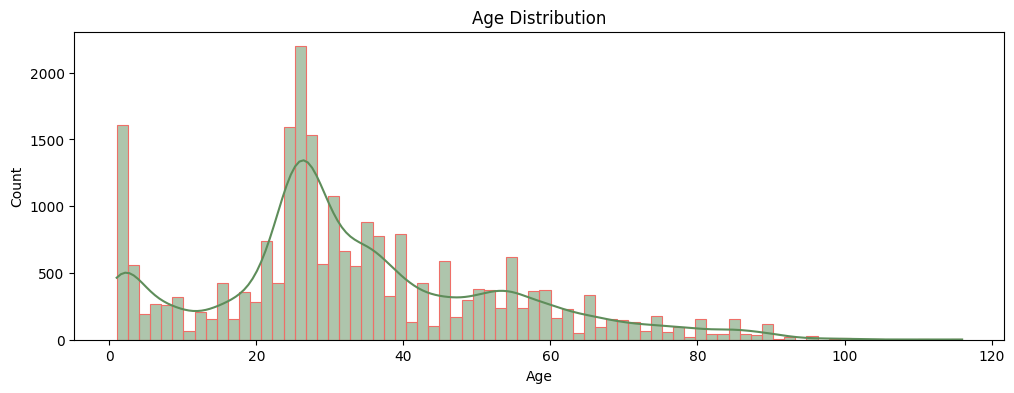

In [182]:
plt.figure(figsize=(12, 4))

sns.histplot(data = df, x='age', color = '#5e8d5a', edgecolor='#ee6f68', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')

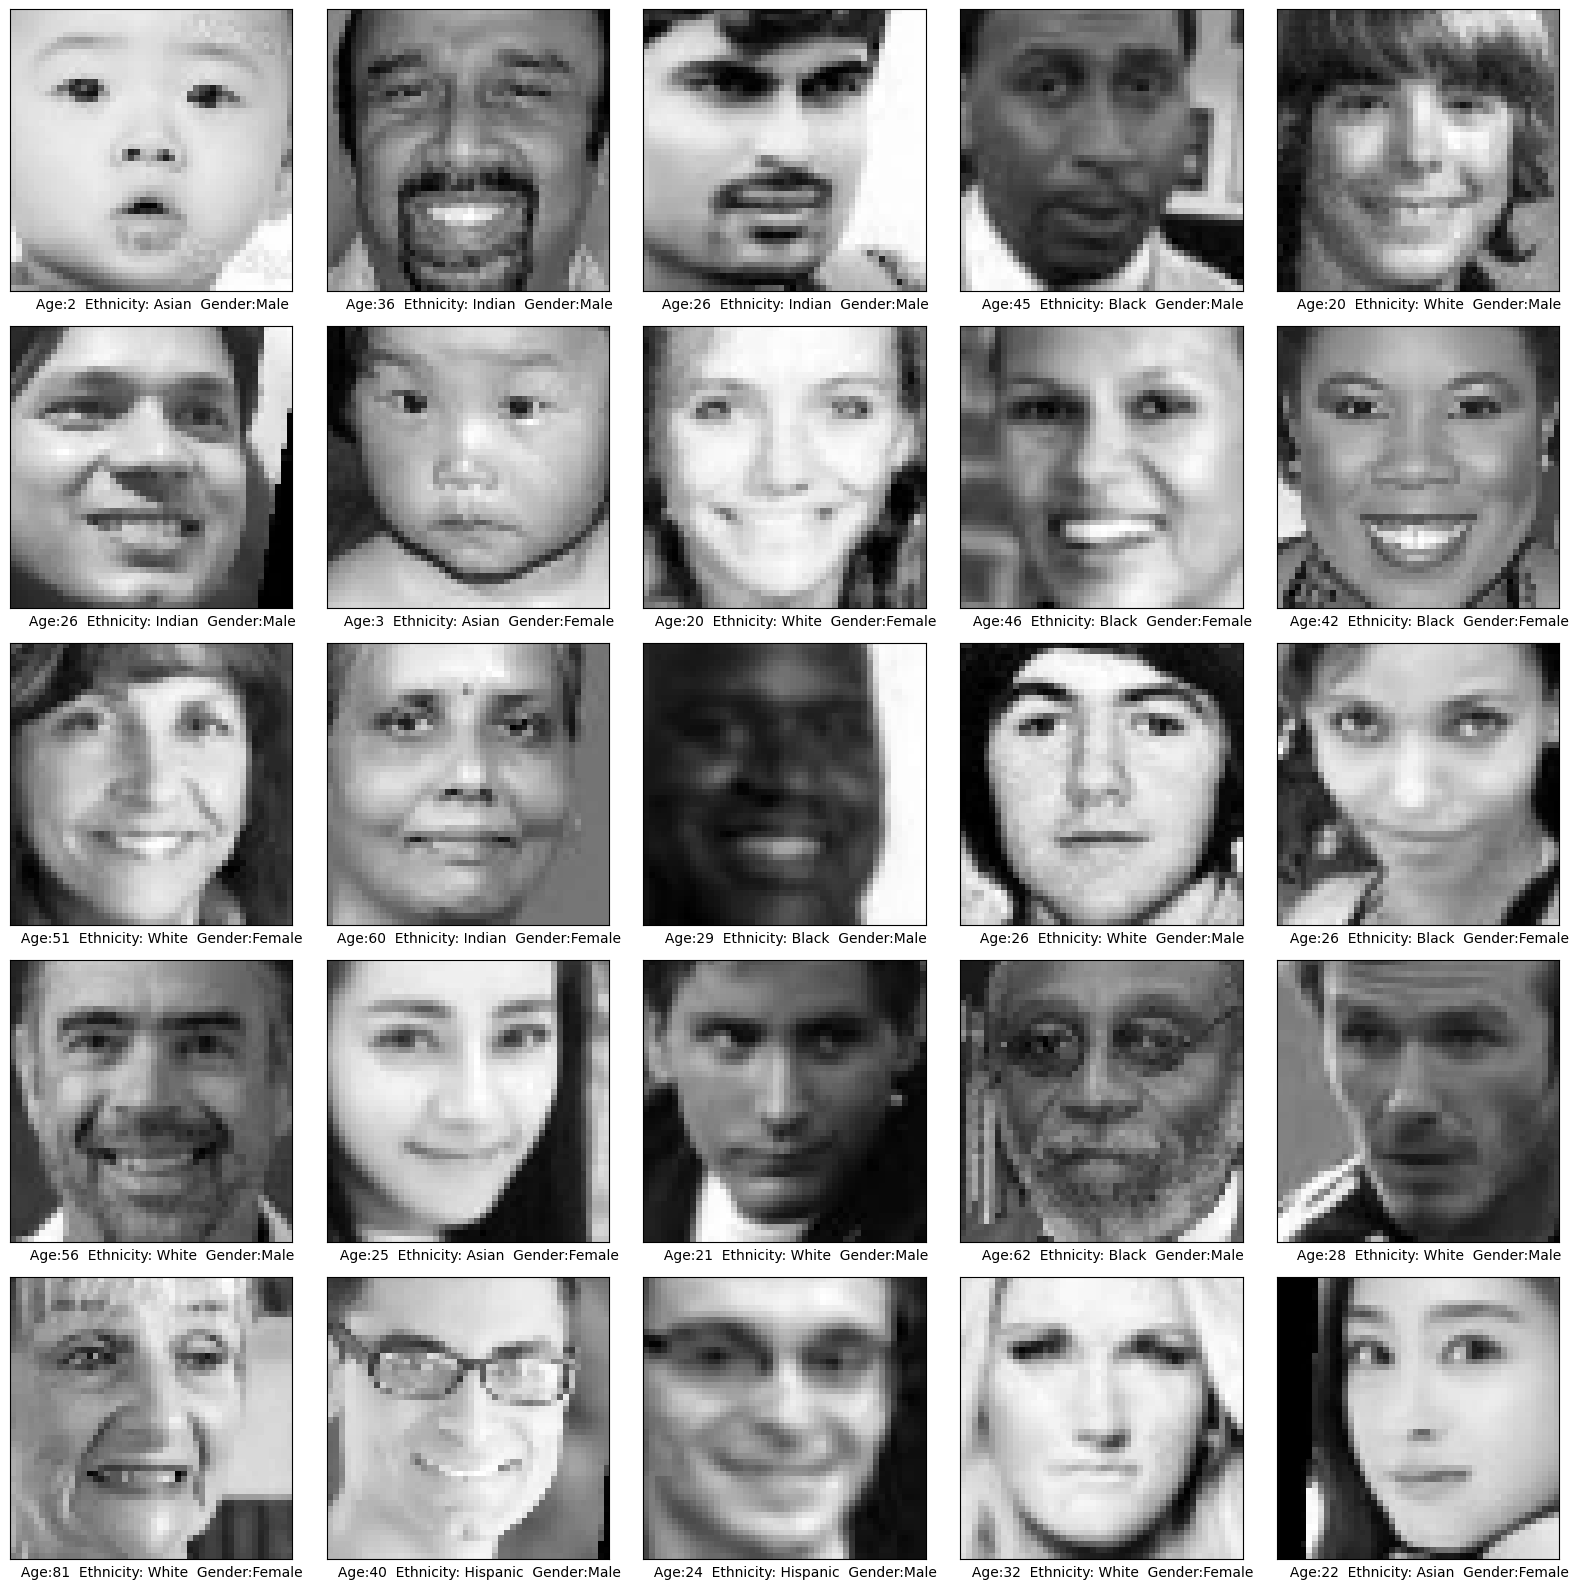

In [183]:
ethnicity_list = ["White", "Black", "Asian", "Indian", "Hispanic"]
gender_list = ['Male', 'Female']

plt.figure(figsize=(16,16))

for i,a in zip(np.random.randint(0, 23705, 25),range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48, 48), cmap ='gray')
    plt.xlabel(
        "     Age:"+str(df['age'].iloc[i])+
        "  Ethnicity: "+ str(ethnicity_list[df['ethnicity'].iloc[i]])+
        "  Gender:"+ str(gender_list[df['gender'].iloc[i]])
    )

plt.tight_layout()
plt.show()

# Data Preparation

This model will predict the age & gender usge the images. A classification model will be used to predict the gender (binary result) while a regression model will be used to predict the age.

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [187]:
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


<Axes: xlabel='age_bin', ylabel='count'>

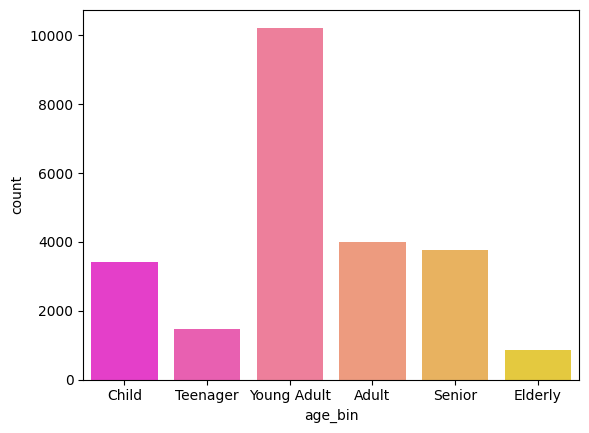

In [188]:
bins = [0, 12, 20, 35, 50, 75, 116]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly']
df['age_bin'] = pd.cut(x = df['age'], bins = bins, labels = labels, include_lowest = True)
df['age_bin'].value_counts()

sns.countplot(data = df, x = 'age_bin', palette = 'spring')

In [189]:
# create label encoding for binning ages
encoder = LabelEncoder()
df['ages_encoded'] = encoder.fit_transform(df['age_bin'])
df.head()

age_mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_ ))
age_mapping

{0: 'Adult',
 1: 'Child',
 2: 'Elderly',
 3: 'Senior',
 4: 'Teenager',
 5: 'Young Adult'}

In [190]:
test, train = train_test_split(df, test_size=0.85, random_state=42)
print(train.shape)
print(test.shape)

(20150, 6)
(3555, 6)


In [191]:
#Reshaping images in training & test datasets

X_train = train['pixels']
# normalizing pixels data
X_train = X_train/255

# reshape images
X_train = np.array(X_train.tolist())
X_train = X_train.reshape(-1,48,48, 1)
print(f"Shape of training images: {X_train.shape}")


X_test = test['pixels']
# normalizing pixels data
X_test = X_test/255

# reshape images
X_test = np.array(X_test.tolist())
X_test = X_test.reshape(-1,48,48, 1)
print(f"Shape of images: {X_test.shape}")

Shape of training images: (20150, 48, 48, 1)
Shape of images: (3555, 48, 48, 1)


In [192]:
# create y training datasets for age regression model

y_train_age = train['age']
y_train_gender = train['gender']
print(f"Age array shape: {(y_train_age.shape)}")
print(f"Gender array shape: {(y_train_gender.shape)}")

y_test_age = test['age']
y_test_gender = test['gender']
print(f"Age array shape: {(y_test_age.shape)}")
print(f"Gender array shape: {(y_test_gender.shape)}")

Age array shape: (20150,)
Gender array shape: (20150,)
Age array shape: (3555,)
Gender array shape: (3555,)


In [193]:
y_train_age_binned = train['ages_encoded']
print(f"Age array shape: {(y_train_age_binned.shape)}")

y_test_age_binned = test['ages_encoded']
print(f"Age array shape: {(y_test_age_binned.shape)}")

Age array shape: (20150,)
Age array shape: (3555,)


In [194]:
input_shape = (48, 48, 1)
num_classes = len(set(y_train_age_binned))

# Model Developmnet

In [195]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from math import sqrt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report

### Age Model - Regression

In [196]:
def predict_age(label, img):
  print(f"Actual age: {label}")

  m_prediction = age_model.predict(img.reshape(-1,48,48, 1), verbose = 0)

  print(f"Predicted age: {m_prediction[0][0]}")

  return

In [197]:
age_model = Sequential([

    # convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Flatten(),

    Dense(128, activation = 'relu'),
    Dropout(0.4),

    Dense(64, activation = 'relu'),
    Dropout(0.4),

    Dense(1, activation = 'relu')

])
age_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse', 'mae'])
age_model.build(input_shape)
age_model.summary()




Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_31 (Ba  (None, 23, 23, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_57 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                     

In [198]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)]

In [199]:
history = age_model.fit(X_train, y_train_age,
                        epochs=30,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test_age))

Epoch 1/30
630/630 [==============================] - 6s 6ms/step - loss: 245.3941 - mse: 245.3941 - mae: 11.5844 - val_loss: 876.1371 - val_mse: 876.1371 - val_mae: 26.6420 - lr: 0.0010
Epoch 2/30
630/630 [==============================] - 3s 6ms/step - loss: 167.7623 - mse: 167.7623 - mae: 9.5024 - val_loss: 100.4013 - val_mse: 100.4013 - val_mae: 7.2303 - lr: 0.0010
Epoch 3/30
630/630 [==============================] - 4s 6ms/step - loss: 145.6750 - mse: 145.6750 - mae: 8.8514 - val_loss: 194.5077 - val_mse: 194.5077 - val_mae: 10.0612 - lr: 0.0010
Epoch 4/30
621/630 [============================>.] - ETA: 0s - loss: 131.0780 - mse: 131.0780 - mae: 8.3951
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
630/630 [==============================] - 3s 5ms/step - loss: 130.7558 - mse: 130.7558 - mae: 8.3812 - val_loss: 111.2825 - val_mse: 111.2825 - val_mae: 7.8198 - lr: 0.0010
Epoch 5/30
630/630 [==============================] - 3s 5ms/step - loss: 108.1796

#### Model Evaluation

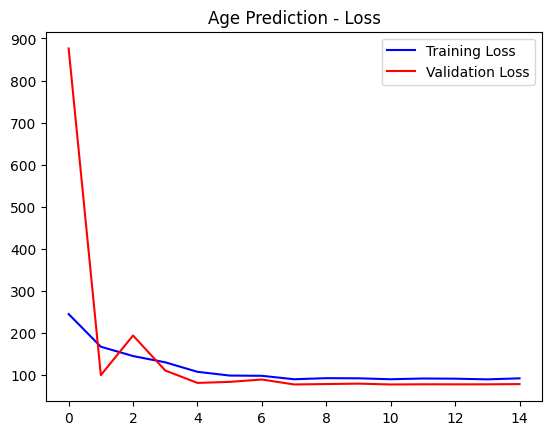

In [200]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Prediction - Loss')
plt.legend()
plt.show()

In [201]:
valid_score = age_model.evaluate(X_test, y_test_age, verbose=1)
valid_score

112/112 [==============================] - 0s 3ms/step - loss: 79.0635 - mse: 79.0635 - mae: 6.1980


[79.06353759765625, 79.06353759765625, 6.197956085205078]

In [202]:
y_pred_age = age_model.predict(X_test)

112/112 [==============================] - 0s 2ms/step


In [203]:
def evaluate_regression_model(a_labels, a_preds):
  plt.scatter(x = a_labels, y = a_preds)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title('Actual vs Predicted Ages')
  print(f"RMSE: {sqrt(mean_squared_error(a_labels, a_preds))}")
  print(f"MAE: {mean_absolute_error(a_labels, a_preds)}")
  return

RMSE: 8.891768011721595
MAE: 6.19795615129833


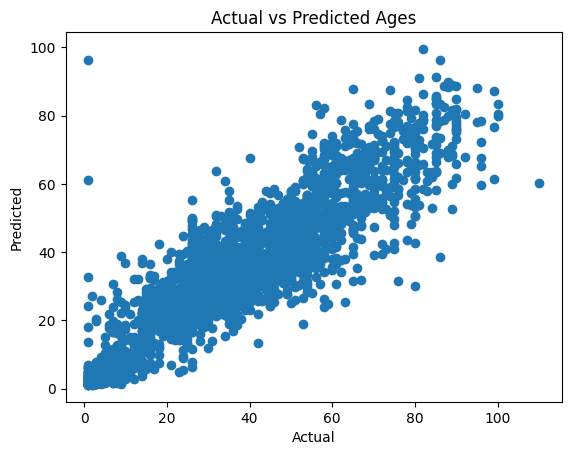

In [204]:
evaluate_regression_model(y_test_age, y_pred_age)

In [205]:
pred = test.sample()
predict_age(pred.values[0][0], pred.values[0][3])

Actual age: 36
Predicted age: 884.4923095703125


### Age Model - Classification (binning ages)

In [206]:
age_model = Sequential([

    # convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Flatten(),

    # Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dropout(0.4),

    Dense(num_classes, activation = 'softmax')

])
age_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
age_model.build(input_shape)
age_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_33 (Ba  (None, 23, 23, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_61 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                     

In [207]:
logdir = os.path.join("logs/age_model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [tensorboard_callback,
             EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)]

history = age_model.fit(X_train, y_train_age_binned,
                        epochs=30,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test_age_binned))

Epoch 1/30
630/630 [==============================] - 6s 6ms/step - loss: 1.1269 - accuracy: 0.5852 - val_loss: 1.7605 - val_accuracy: 0.4160 - lr: 0.0010
Epoch 2/30
630/630 [==============================] - 3s 5ms/step - loss: 0.9009 - accuracy: 0.6533 - val_loss: 0.9330 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 3/30
630/630 [==============================] - 4s 6ms/step - loss: 0.8193 - accuracy: 0.6830 - val_loss: 0.8367 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 4/30
630/630 [==============================] - 4s 6ms/step - loss: 0.7637 - accuracy: 0.6995 - val_loss: 1.4338 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 5/30
621/630 [============================>.] - ETA: 0s - loss: 0.7123 - accuracy: 0.7160
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
630/630 [==============================] - 3s 5ms/step - loss: 0.7122 - accuracy: 0.7157 - val_loss: 1.3378 - val_accuracy: 0.6096 - lr: 0.0010
Epoch 6/30
630/630 [==============================] - 3s 6ms/st

In [208]:
age_model.save('/content/drive/MyDrive/comp4449_final/content 2/models/age/5')

In [209]:
# from tensorboard import notebook
# # notebook.list()
# # # load tensorboard
# # # notebook.display(port=6006, height=1000)
# %load_ext tensorboard
# %tensorboard --logdir logs

#### Model Evaluation

https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning

Model 0 - loss: 0.7605 - accuracy: 0.7241 <br>
Model 1 - loss: 0.7773 - accuracy: 0.7128 <br>
Model 2 - loss: 0.8540 - accuracy: 0.7072 <br>
Model 3 - loss: 0.8607 - accuracy: 0.7086 <br>
Model 4 - loss: 0.8142 - accuracy: 0.7122 <br>
Model 5 - loss: 0.7994 - accuracy: 0.7274 <br>

** Model 0 & 5 seem to be performing the best, took out dense later in model 5

In [210]:
def evaluate_classification_model(labels, preds, cm_labels):

  cm = confusion_matrix(labels, preds)
  sns.heatmap(cm, annot = True, fmt ='.0f', xticklabels=cm_labels, yticklabels=cm_labels)
  plt.ylabel('True Label')
  plt.xlabel('Predictied Label')
  plt.title('Age Bin Classficiation')
  # print(f"Accuracy: {accuracy_score(labels, preds)}")
  # print(f"Precision: {precision_score(labels, preds)}")
  # print(f"Recall: {recall_score(labels, preds)}")
  # print(f"F1 Score: {f1_score(labels, preds)}")
  print(classification_report(labels, preds, target_names = cm_labels))

  return

def predict_age(age, label, img):
  print(f"Actual age: {age}")
  print(f"Actual age group: {label}")

  m_prediction = age_model.predict(img.reshape(-1,48,48, 1), verbose = 0)

  print(f"Predicted age group: {age_mapping[np.argmax(m_prediction, axis = 1)[0]]}")

  return

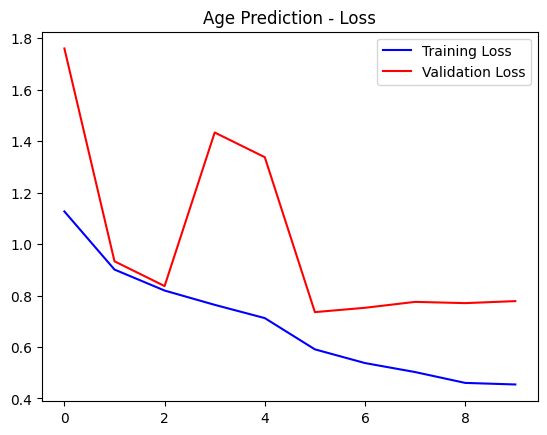

In [211]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Prediction - Loss')
plt.legend()
plt.show()

In [212]:
valid_score = age_model.evaluate(X_test, y_test_age_binned, verbose=1)

112/112 [==============================] - 0s 2ms/step - loss: 0.7782 - accuracy: 0.7181


In [213]:
y_pred_age = age_model.predict(X_test)
pred_classes = np.argmax(y_pred_age,axis=1)

112/112 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

       Adult       0.48      0.42      0.45       585
       Child       0.93      0.91      0.92       488
     Elderly       0.67      0.61      0.64       153
      Senior       0.69      0.67      0.68       574
    Teenager       0.53      0.32      0.40       232
 Young Adult       0.76      0.86      0.81      1523

    accuracy                           0.72      3555
   macro avg       0.68      0.63      0.65      3555
weighted avg       0.71      0.72      0.71      3555



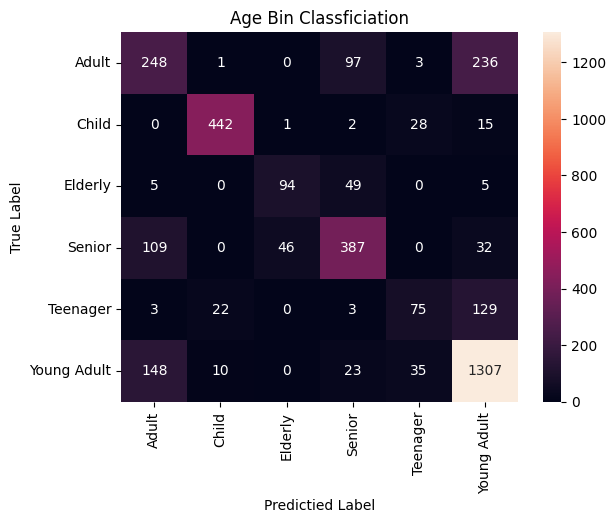

In [214]:
evaluate_classification_model(y_test_age_binned.values, pred_classes, list(encoder.classes_))

In [215]:
pred = test.sample()
predict_age(pred.values[0][0], pred.values[0][4], pred.values[0][3])
# test.iloc[0]

Actual age: 15
Actual age group: Teenager
Predicted age group: Young Adult
